#### Imports

In [1]:
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from skfuzzy import control as ctrl
import numpy as np
import skfuzzy as fuzz


In [2]:
sepsis_folder_path = "D:/fuzzy/sepsis_dataset-2/sepsis_dataset-2/dataset/sepsis"
no_sepsis_folder_path = "D:/fuzzy/sepsis_dataset-2/sepsis_dataset-2/dataset/no_sepsis"

# Get the file list
sepsis_files = os.listdir(sepsis_folder_path)
no_sepsis_files = os.listdir(no_sepsis_folder_path)


sample_sepsis_file = pd.read_csv(os.path.join(sepsis_folder_path, sepsis_files[0]))
(sample_sepsis_file.head()) 

,heart_rate,bp_systolic,bp_diastolic,map,resp,temp,spo2,fio2,wbc,bun,...,bicarbonate,hemoglobin,hematocrit,potassium,chloride,gcs,age,sirs,qsofa,sepsis_icd
0,72.0,109.0,40.0,57.0,12.0,36.500000,96.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,58.59,0.0,0.0,1.0
1,72.0,116.0,41.0,59.0,18.0,36.500000,98.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,58.59,0.0,0.0,1.0
2,70.0,119.0,38.0,59.0,14.0,36.500000,98.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,58.59,0.0,0.0,1.0
3,74.0,131.0,45.0,67.0,15.0,36.500000,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,58.59,0.0,0.0,1.0
4,75.0,119.0,41.0,61.0,14.0,36.888889,95.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,58.59,0.0,0.0,1.0


#### Randomly select 200 data files each from the sepsis and no-sepsis datasets

In [3]:
random_state = 42

random.seed(random_state)

sepsis_sample_files_ = random.sample(sepsis_files, 200)
no_sepsis_sample_files_ = random.sample(no_sepsis_files, 200)
sepsis_sample_files=[]
for file in sepsis_sample_files_:
    sepsis_sample_files.append(file)
    
no_sepsis_sample_files=[]
for file in no_sepsis_sample_files_:
    no_sepsis_sample_files.append(file)

#### Assigning all data for sepsis and no-sepsis cases separately to individual DataFrames (using the first 12 hours of data).

In [4]:
def combine_df(sample_files,folder_path):
    data = [] 
    labels = []  # Sepsis label

    for file in sample_files: 
        file=os.path.join(folder_path, file)
        df = pd.read_csv(file)  
        first_12_rows = df.iloc[:12]  # take first 12 rows
        data.append(first_12_rows) 

    combined_df = pd.concat(data, ignore_index=True)
    return combined_df
    
sepsis_combined_df = combine_df(sepsis_sample_files, sepsis_folder_path)
no_sepsis_combined_df = combine_df(no_sepsis_sample_files,no_sepsis_folder_path)

#### Droping the column if the percentage of NaN values exceeds 45% (because filling them wouldn't be very meaningful)

In [5]:
def dropnan(combined_df):
    dropped_nan=combined_df
    for column in dropped_nan.columns:
        nan_percentage=dropped_nan[column].isnull().sum()/2400 
        if(nan_percentage*100 >45):
            dropped_nan.drop(column, axis=1, inplace=True)
    return dropped_nan

sepsis_dropped_nan=dropnan(sepsis_combined_df)
no_sepsis_dropped_nan=dropnan(no_sepsis_combined_df)

#### Function to calculate the number of positive and negative instances

In [6]:
def neg_pos(df):
    columns=df.columns
    
    for col in columns:
        neg=0
        for row in df[col]:
            if int(row)<0:
                neg=neg+1
            pos=4800-neg
        print(f"For column {col} number of negative instances {neg} number of positive instances {pos}")
          
            
        

#### Function to visualize data distributions for the given DataFrame

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data_distributions(df, title="Data Distributions", save_fig=False):
    num_columns = len(df.columns)
    rows = (num_columns // 3) + 1  # Create rows dynamically based on the number of columns
    plt.figure(figsize=(15, rows * 5))
    
    for i, column in enumerate(df.columns, 1):
        plt.subplot(rows, 3, i)  # 3 columns per row
        sns.histplot(df[column], kde=True, color="blue", bins=30)
        plt.title(f"{column} Distribution")
        plt.xlabel(column)
        plt.ylabel("Frequency")
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
    if save_fig:
        plt.savefig(f"{title.replace(' ', '_').lower()}.png", dpi=300)
    plt.show()


#### Handling NaN values (either filling or removing them) before normalization

In [8]:
nan_cleaned_df_sepsis = sepsis_dropped_nan.dropna()

filled_df_sepsis = sepsis_dropped_nan.fillna(sepsis_dropped_nan.mean())


In [9]:
filled_df_sepsis.describe()

,heart_rate,bp_systolic,bp_diastolic,map,resp,temp,spo2,wbc,bun,creatinine,...,bicarbonate,hemoglobin,hematocrit,potassium,chloride,gcs,age,sirs,qsofa,sepsis_icd
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.0
mean,94.547392,110.829235,58.172131,73.338980,21.363144,36.740739,96.855975,16.189661,37.599075,2.025495,...,21.560237,10.170733,30.670456,4.128328,105.788250,11.895833,66.448467,0.565939,0.407424,1.0
std,19.106667,21.454907,13.909715,14.279383,7.283002,2.713659,3.881495,12.240125,22.766605,1.814425,...,4.033945,1.553204,4.635607,0.603097,5.474734,3.573011,15.566258,0.484242,0.480063,0.0
min,40.000000,0.000000,0.000000,21.000000,0.000000,-17.777778,28.000000,0.100000,2.000000,0.200000,...,8.000000,5.900000,17.300000,2.600000,83.000000,3.000000,20.810000,0.000000,0.000000,1.0
25%,81.000000,97.000000,49.000000,64.000000,17.000000,36.222222,96.000000,11.400000,23.000000,1.100000,...,20.000000,9.700000,28.700000,3.800000,103.000000,10.000000,55.520000,0.000000,0.000000,1.0
50%,94.547392,109.000000,58.172131,73.000000,21.000000,36.740739,97.000000,16.189661,37.599075,2.025495,...,21.560237,10.170733,30.670456,4.128328,105.788250,13.000000,66.448467,1.000000,0.000000,1.0
75%,107.000000,121.000000,66.000000,80.000000,24.000000,37.500000,99.000000,16.189661,37.599075,2.025495,...,23.000000,10.600000,31.800000,4.300000,108.000000,15.000000,78.300000,1.000000,1.000000,1.0
max,169.000000,221.000000,160.000000,151.000000,211.000000,40.222223,100.000000,186.600000,158.000000,19.700000,...,38.000000,18.300000,54.300000,7.100000,126.000000,15.000000,91.400000,1.000000,1.000000,1.0


In [10]:
neg_pos(filled_df_sepsis)

For column heart_rate number of negative instances 0 number of positive instances 4800
For column bp_systolic number of negative instances 0 number of positive instances 4800
For column bp_diastolic number of negative instances 0 number of positive instances 4800
For column map number of negative instances 0 number of positive instances 4800
For column resp number of negative instances 0 number of positive instances 4800
For column temp number of negative instances 4 number of positive instances 4796
For column spo2 number of negative instances 0 number of positive instances 4800
For column wbc number of negative instances 0 number of positive instances 4800
For column bun number of negative instances 0 number of positive instances 4800
For column creatinine number of negative instances 0 number of positive instances 4800
For column platelets number of negative instances 0 number of positive instances 4800
For column bicarbonate number of negative instances 0 number of positive instanc

In [11]:
nan_cleaned_df_no_sepsis = no_sepsis_dropped_nan.dropna()

filled_df_no_sepsis = no_sepsis_dropped_nan.fillna(no_sepsis_dropped_nan.mean())

In [12]:
filled_df_no_sepsis.describe()

,heart_rate,bp_systolic,bp_diastolic,map,resp,temp,spo2,wbc,bun,creatinine,...,bicarbonate,hemoglobin,hematocrit,potassium,chloride,gcs,age,sirs,qsofa,sepsis_icd
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.0
mean,83.849977,120.221607,60.072484,78.260368,18.482110,36.711646,97.688623,12.651661,24.503743,1.361820,...,23.592428,11.075949,32.196027,4.144808,105.262865,11.456522,64.292731,0.303376,0.218325,0.0
std,17.595202,22.620596,14.483862,15.422137,5.247136,1.342459,2.636480,5.217429,14.370173,1.068392,...,3.513165,1.626812,4.790854,0.534640,4.761535,3.801821,18.198224,0.448267,0.402821,0.0
min,30.000000,0.000000,0.000000,1.000000,0.000000,-17.777778,50.000000,1.200000,3.000000,0.400000,...,7.000000,3.200000,12.100000,2.100000,83.000000,3.000000,18.430000,0.000000,0.000000,0.0
25%,71.000000,105.000000,50.000000,68.000000,15.000000,36.277779,96.000000,11.100000,16.000000,0.900000,...,23.000000,10.500000,30.300000,3.900000,105.000000,10.000000,51.750000,0.000000,0.000000,0.0
50%,83.849977,120.110803,60.072484,78.000000,18.000000,36.711646,98.000000,12.651661,24.503743,1.361820,...,23.592428,11.075949,32.196027,4.144808,105.262865,11.456522,64.431366,0.000000,0.000000,0.0
75%,94.000000,133.000000,67.000000,86.416649,21.000000,37.111113,100.000000,12.651661,24.503743,1.361820,...,24.000000,11.500000,32.900000,4.200000,107.000000,15.000000,78.750000,1.000000,0.218325,0.0
max,157.000000,215.000000,141.000000,154.000000,47.000000,39.333335,100.000000,47.700000,113.000000,14.300000,...,48.000000,16.600000,47.800000,8.300000,120.000000,15.000000,91.400000,1.000000,1.000000,0.0


In [13]:
neg_pos(filled_df_no_sepsis)

For column heart_rate number of negative instances 0 number of positive instances 4800
For column bp_systolic number of negative instances 0 number of positive instances 4800
For column bp_diastolic number of negative instances 0 number of positive instances 4800
For column map number of negative instances 0 number of positive instances 4800
For column resp number of negative instances 0 number of positive instances 4800
For column temp number of negative instances 1 number of positive instances 4799
For column spo2 number of negative instances 0 number of positive instances 4800
For column wbc number of negative instances 0 number of positive instances 4800
For column bun number of negative instances 0 number of positive instances 4800
For column creatinine number of negative instances 0 number of positive instances 4800
For column platelets number of negative instances 0 number of positive instances 4800
For column bicarbonate number of negative instances 0 number of positive instanc

#### Combining common columns in sepsis and non-sepsis DataFrames

In [14]:
common_columns_ = filled_df_no_sepsis.columns.intersection(filled_df_sepsis.columns)
combined_df_filled = pd.concat([filled_df_no_sepsis[common_columns_], filled_df_sepsis[common_columns_]], ignore_index=True)


#### Perform normalization before calculating the correlation matrix for both filled and cleaned datasets separately.

#### -sepsis data

In [15]:
# Min-Max normalization
scaler = MinMaxScaler()
features = nan_cleaned_df_sepsis.drop('sepsis_icd', axis=1)
sepsis_cleaned_data = scaler.fit_transform(nan_cleaned_df_sepsis)

# new dataframe
sepsis_cleaned_df = pd.DataFrame(sepsis_cleaned_data, columns=nan_cleaned_df_sepsis.columns)
sepsis_cleaned_df['sepsis_icd']=1.0

In [16]:
# Min-Max normalization
scaler = MinMaxScaler()
sepsis_filled_data = scaler.fit_transform(filled_df_sepsis)

# new dataframe
sepsis_filled_df = pd.DataFrame(sepsis_filled_data, columns=filled_df_sepsis.columns)
sepsis_filled_df['sepsis_icd']=1.0

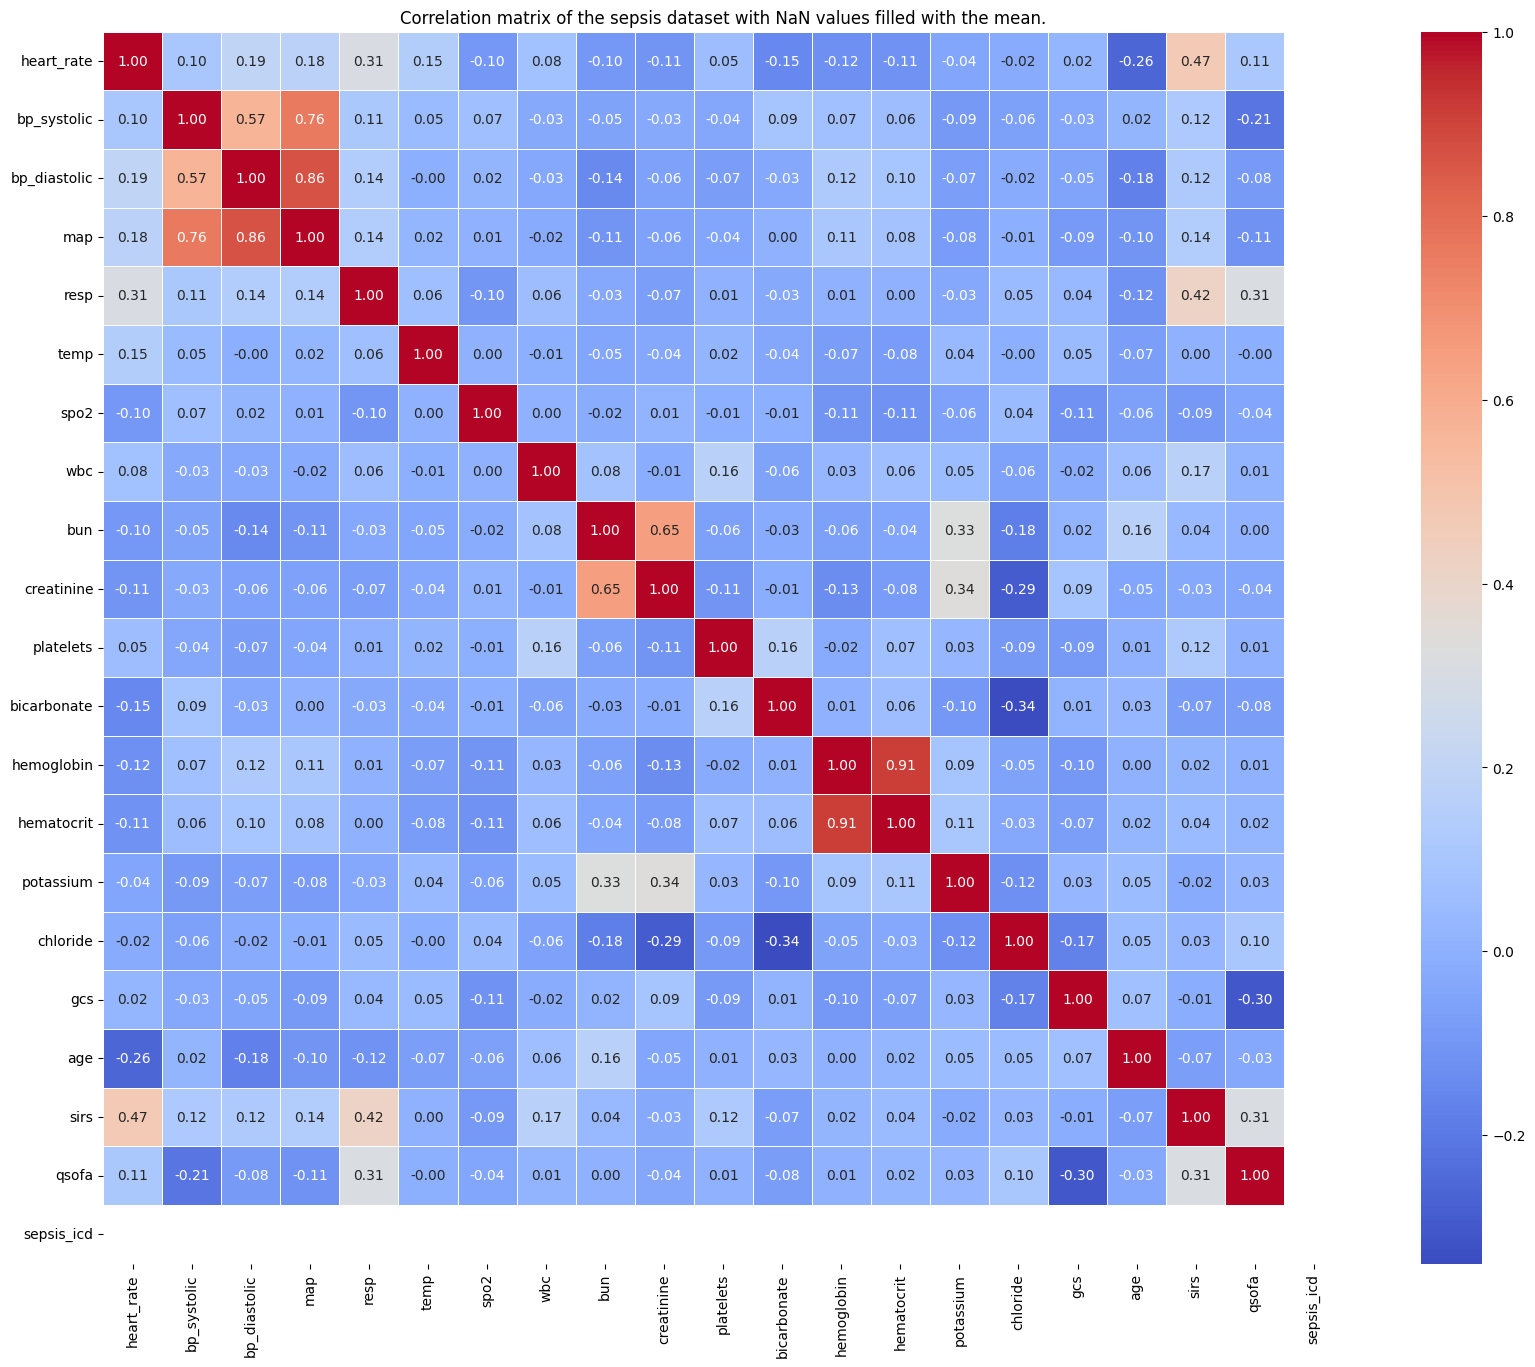

In [17]:
#Correlation matrix
correlation_matrix = sepsis_filled_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation matrix of the sepsis dataset with NaN values filled with the mean.")
plt.show()

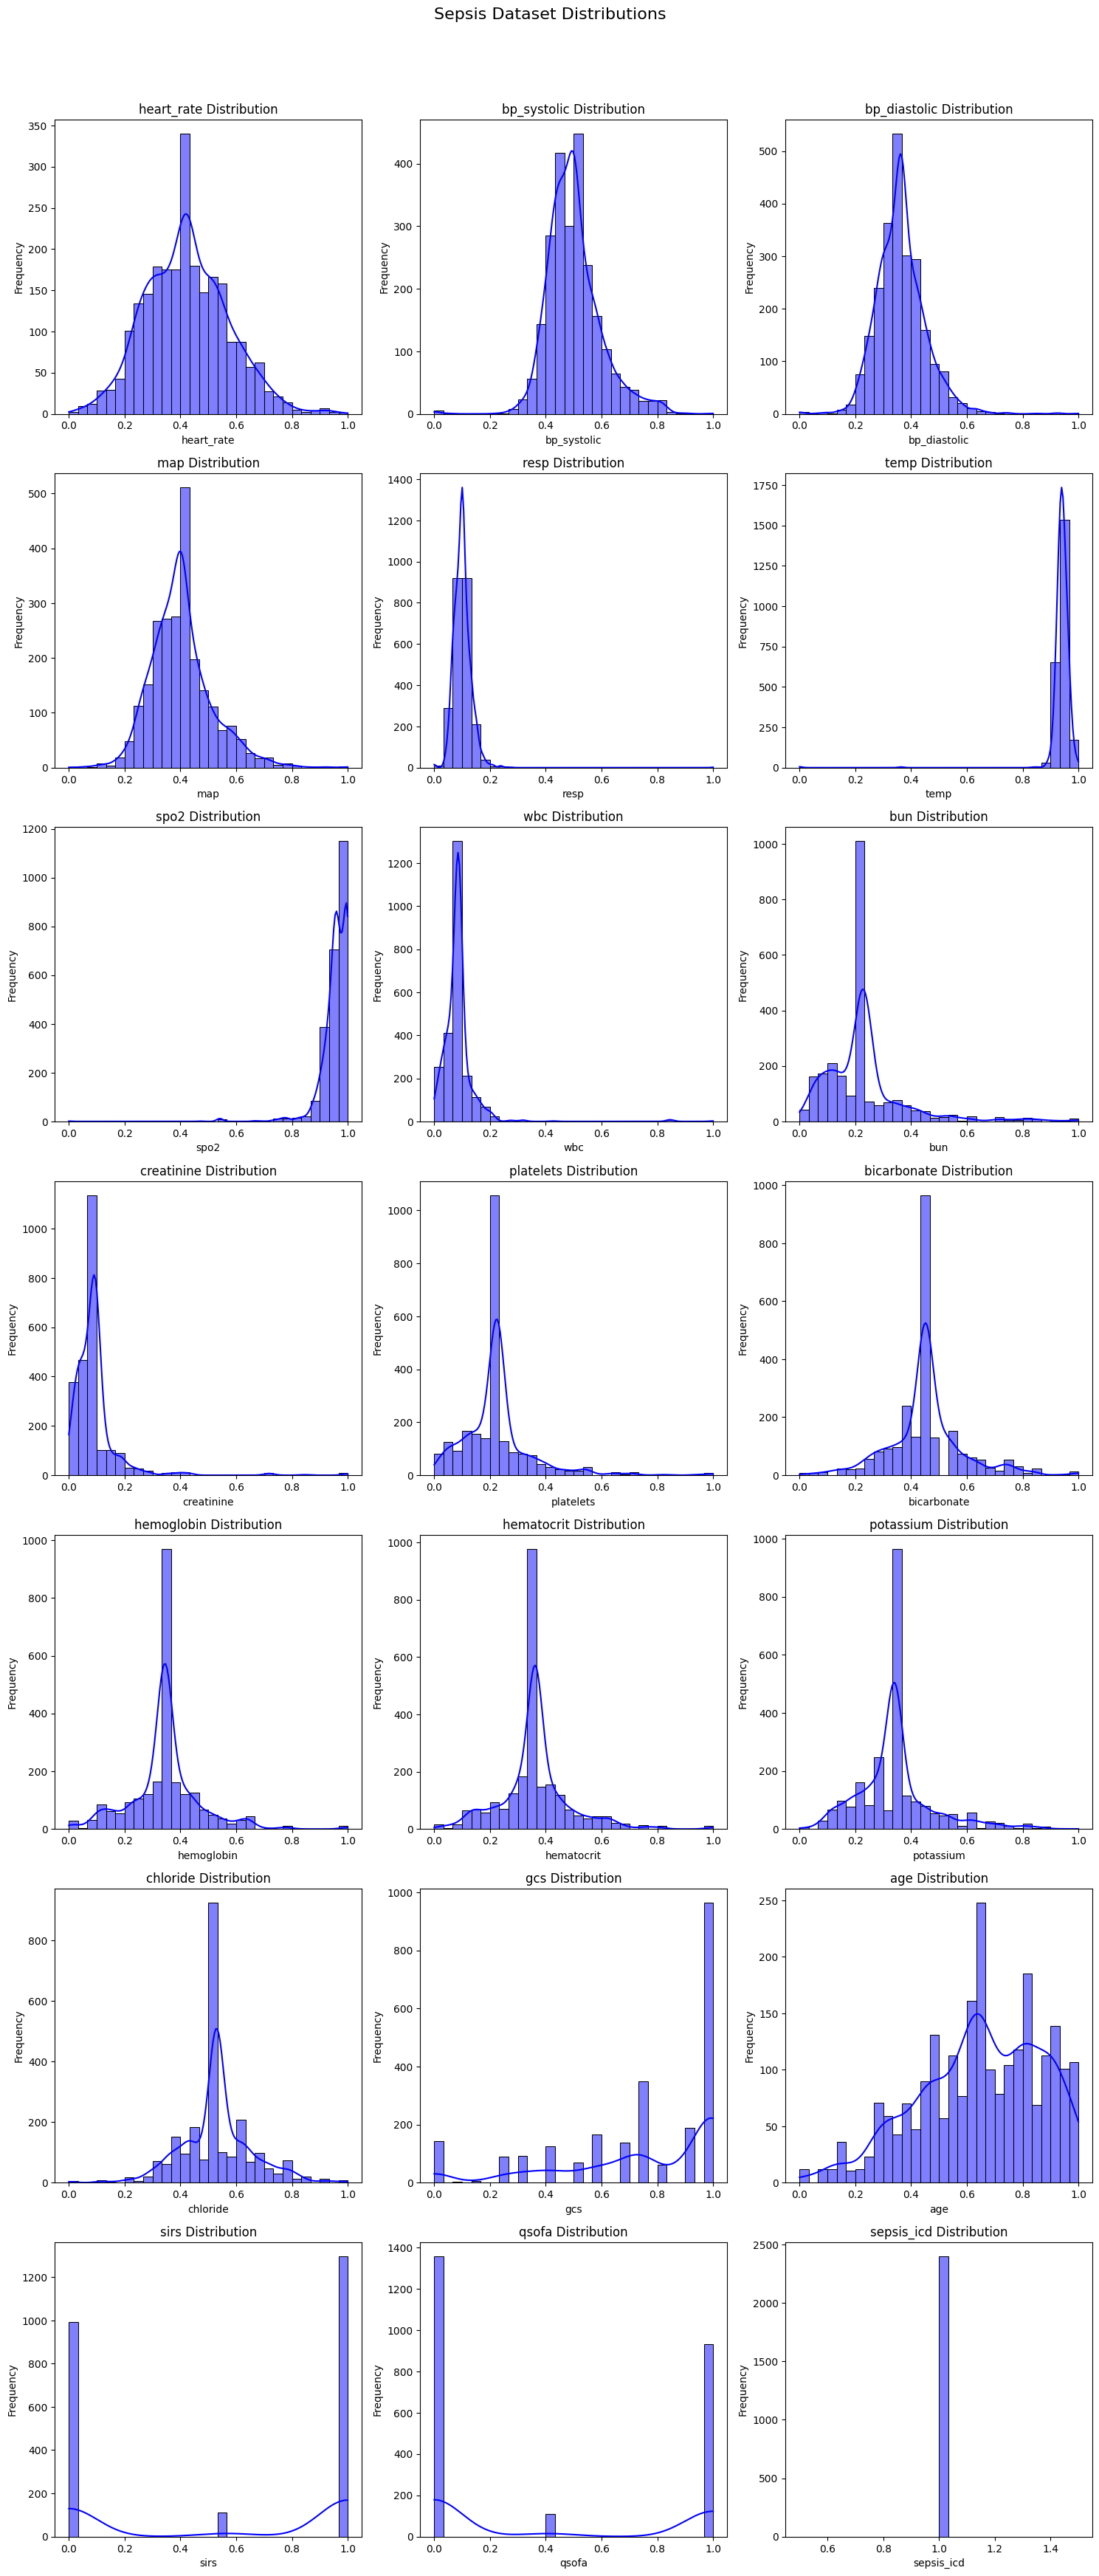

In [18]:
visualize_data_distributions(sepsis_filled_df, title="Sepsis Dataset Distributions")

#### -no sepsis data

In [19]:
scaler = MinMaxScaler()
no_sepsis_cleaned_data = scaler.fit_transform(nan_cleaned_df_no_sepsis)

no_sepsis_cleaned_df = pd.DataFrame(no_sepsis_cleaned_data, columns=nan_cleaned_df_no_sepsis.columns)

In [20]:
scaler = MinMaxScaler()
no_sepsis_filled_data = scaler.fit_transform(filled_df_no_sepsis)

no_sepsis_filled_df = pd.DataFrame(no_sepsis_filled_data, columns=filled_df_no_sepsis.columns)

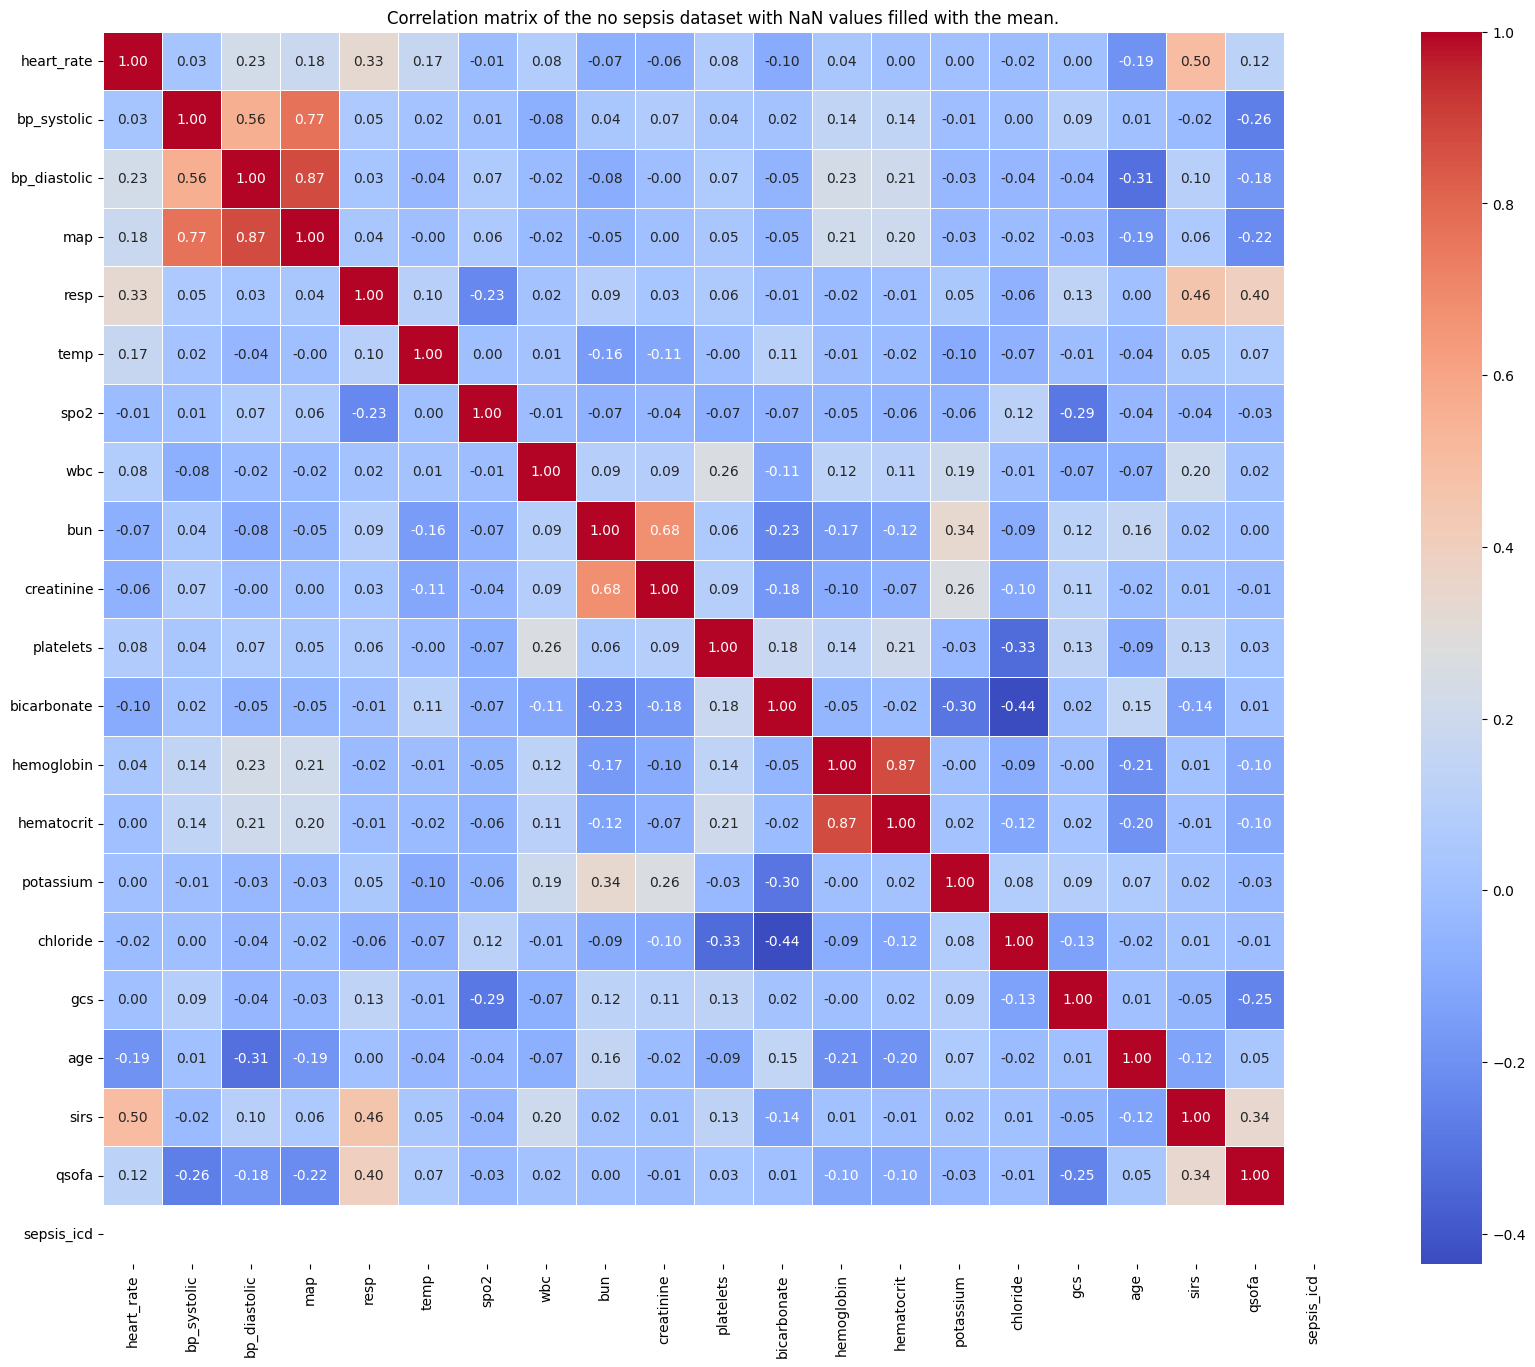

In [21]:

correlation_matrix = no_sepsis_filled_df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation matrix of the no sepsis dataset with NaN values filled with the mean.")
plt.show()

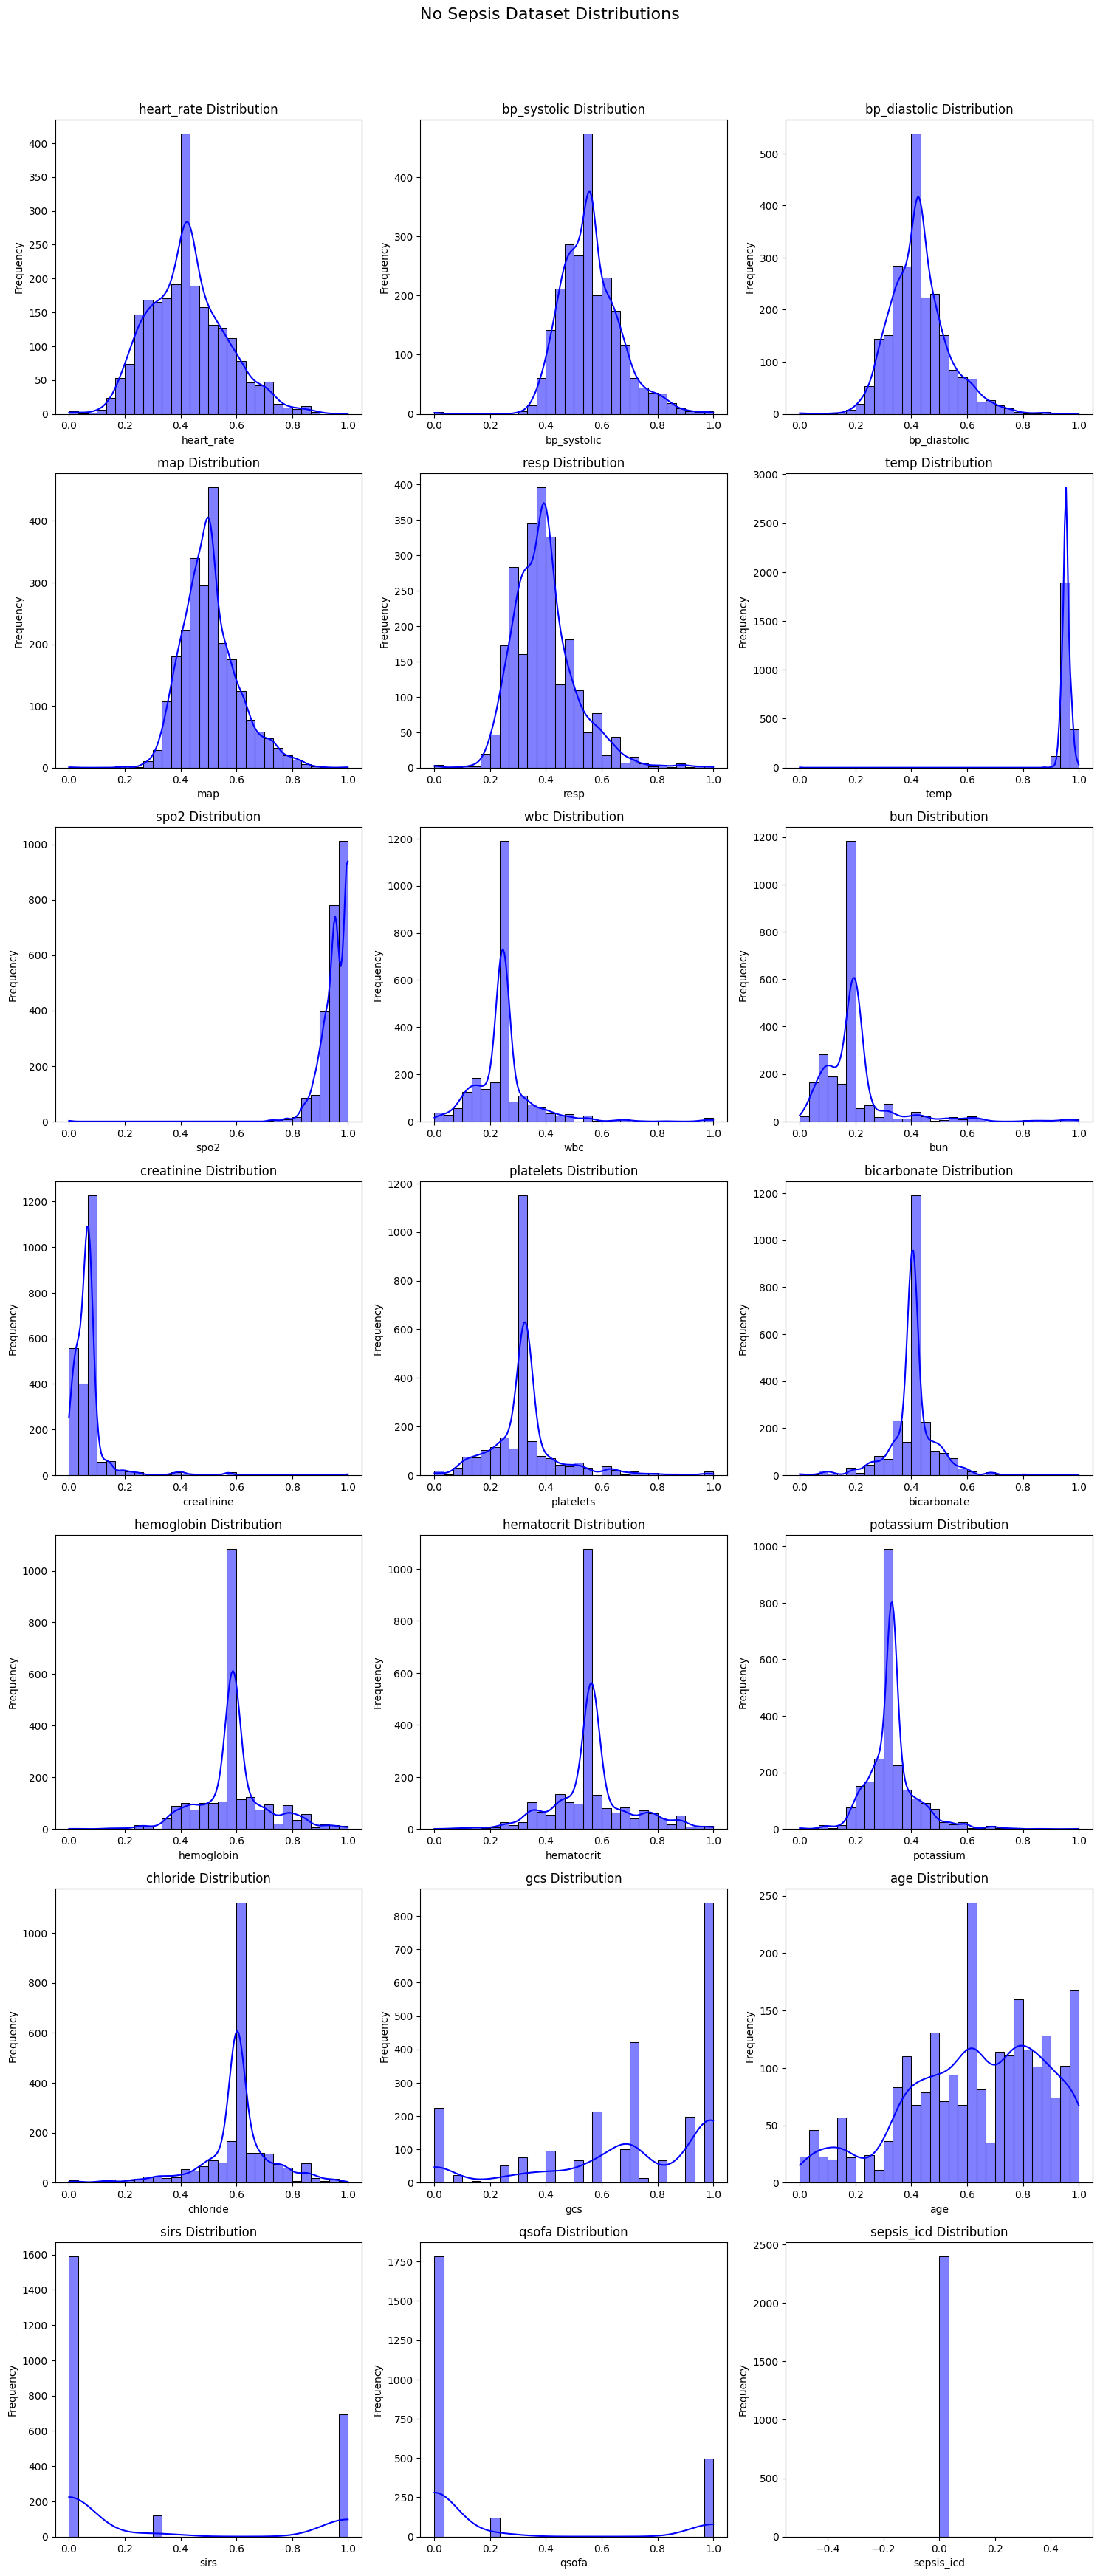

In [22]:
visualize_data_distributions(no_sepsis_filled_df, title="No Sepsis Dataset Distributions")

#### Combined data of normalized sepsis and no-sepsis datasets

In [23]:
common_columns = no_sepsis_filled_df.columns.intersection(sepsis_filled_df.columns)
combined_df = pd.concat([no_sepsis_filled_df[common_columns], sepsis_filled_df[common_columns]], ignore_index=True)
combined_df.head()

,heart_rate,bp_systolic,bp_diastolic,map,resp,temp,spo2,wbc,bun,creatinine,...,bicarbonate,hemoglobin,hematocrit,potassium,chloride,gcs,age,sirs,qsofa,sepsis_icd
0,0.314961,0.925581,0.539007,0.705882,0.361702,0.948444,0.90,0.246272,0.195489,0.069196,...,0.404693,0.587757,0.562914,0.329808,0.601699,0.70471,1.0,0.0,0.0,0.0
1,0.291339,0.920930,0.624113,0.745098,0.531915,0.948444,0.86,0.193548,0.354545,0.035971,...,0.487805,0.835821,0.873950,0.306452,0.756757,0.70471,1.0,0.0,0.0,0.0
2,0.370079,0.879070,0.496454,0.627451,0.531915,0.948444,0.86,0.193548,0.354545,0.035971,...,0.487805,0.835821,0.873950,0.306452,0.756757,1.00000,1.0,0.0,0.0,0.0
3,0.314961,0.744186,0.418440,0.535948,0.489362,0.948444,0.86,0.193548,0.354545,0.035971,...,0.487805,0.835821,0.873950,0.306452,0.756757,1.00000,1.0,0.0,0.0,0.0
4,0.259843,0.744186,0.418440,0.535948,0.404255,0.948444,0.86,0.193548,0.354545,0.035971,...,0.487805,0.835821,0.873950,0.306452,0.756757,1.00000,1.0,0.0,0.0,0.0


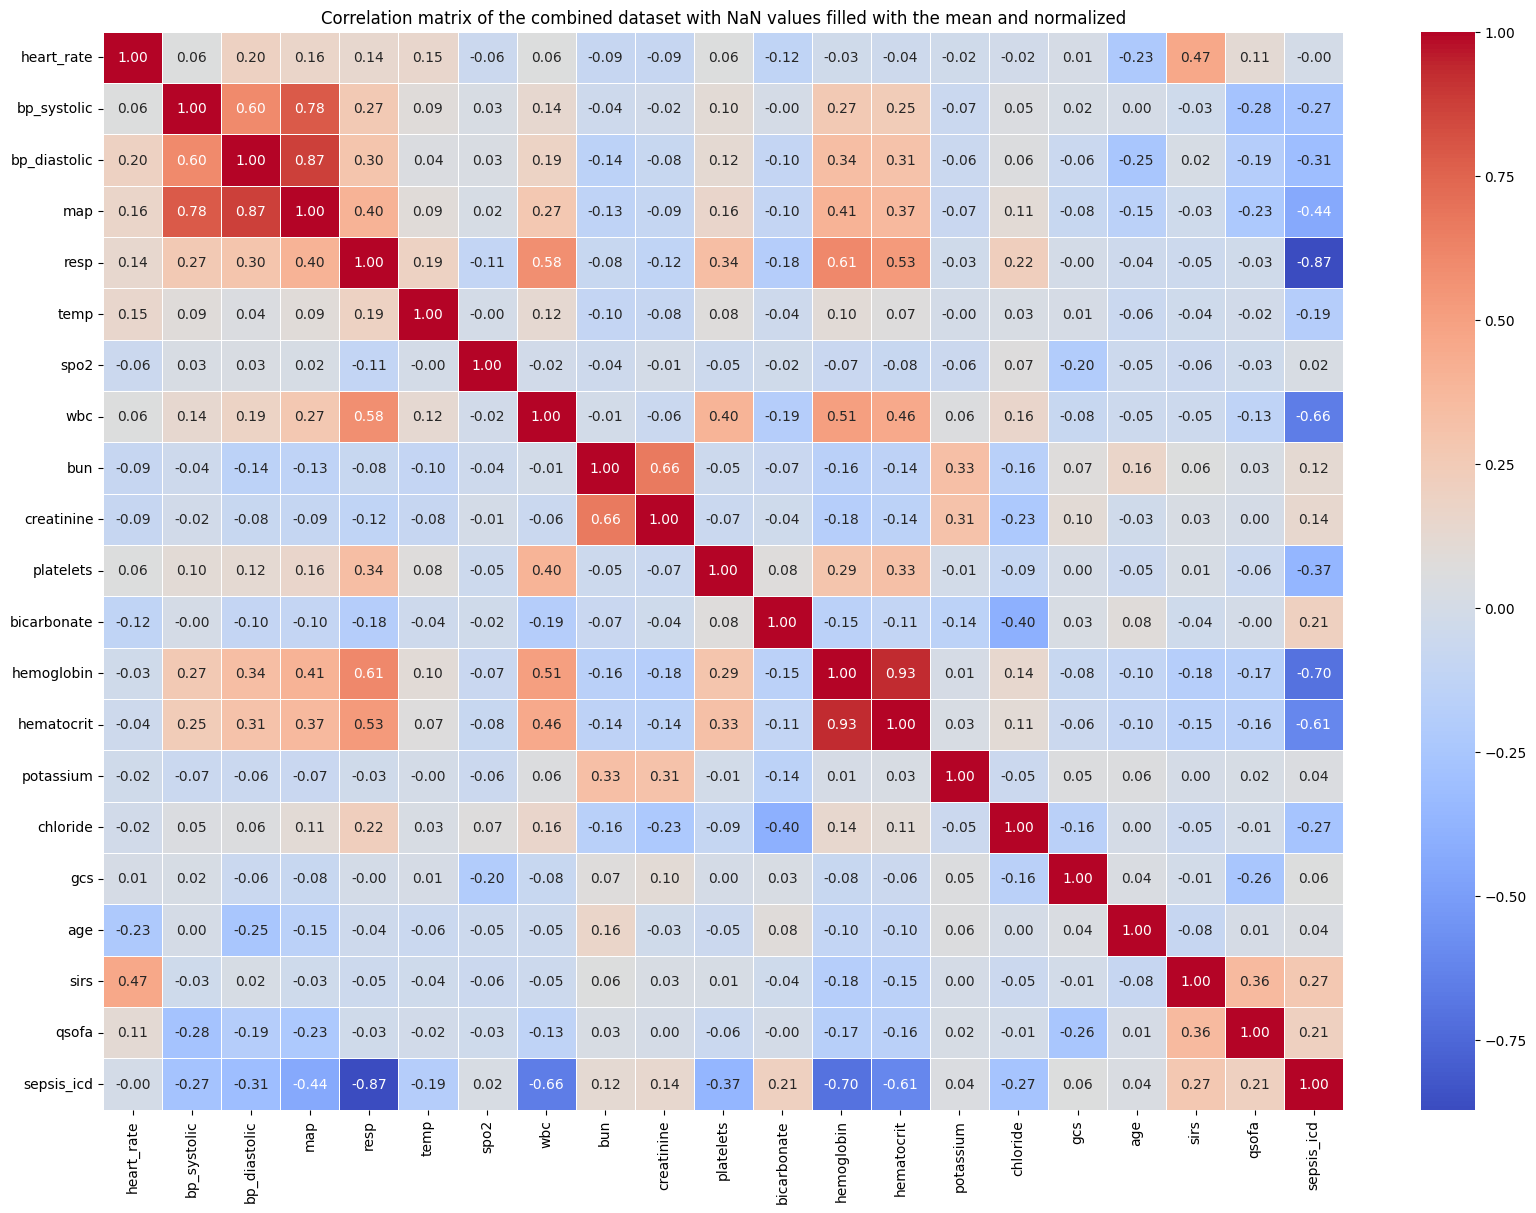

In [24]:
correlation_matrix = combined_df.corr()

plt.figure(figsize=(20, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation matrix of the combined dataset with NaN values filled with the mean and normalized")
plt.show()

### To determine the correct boundaries for the selected columns for FIS implementation, the distributions of those columns in the sepsis and no-sepsis DataFrames were visualized.

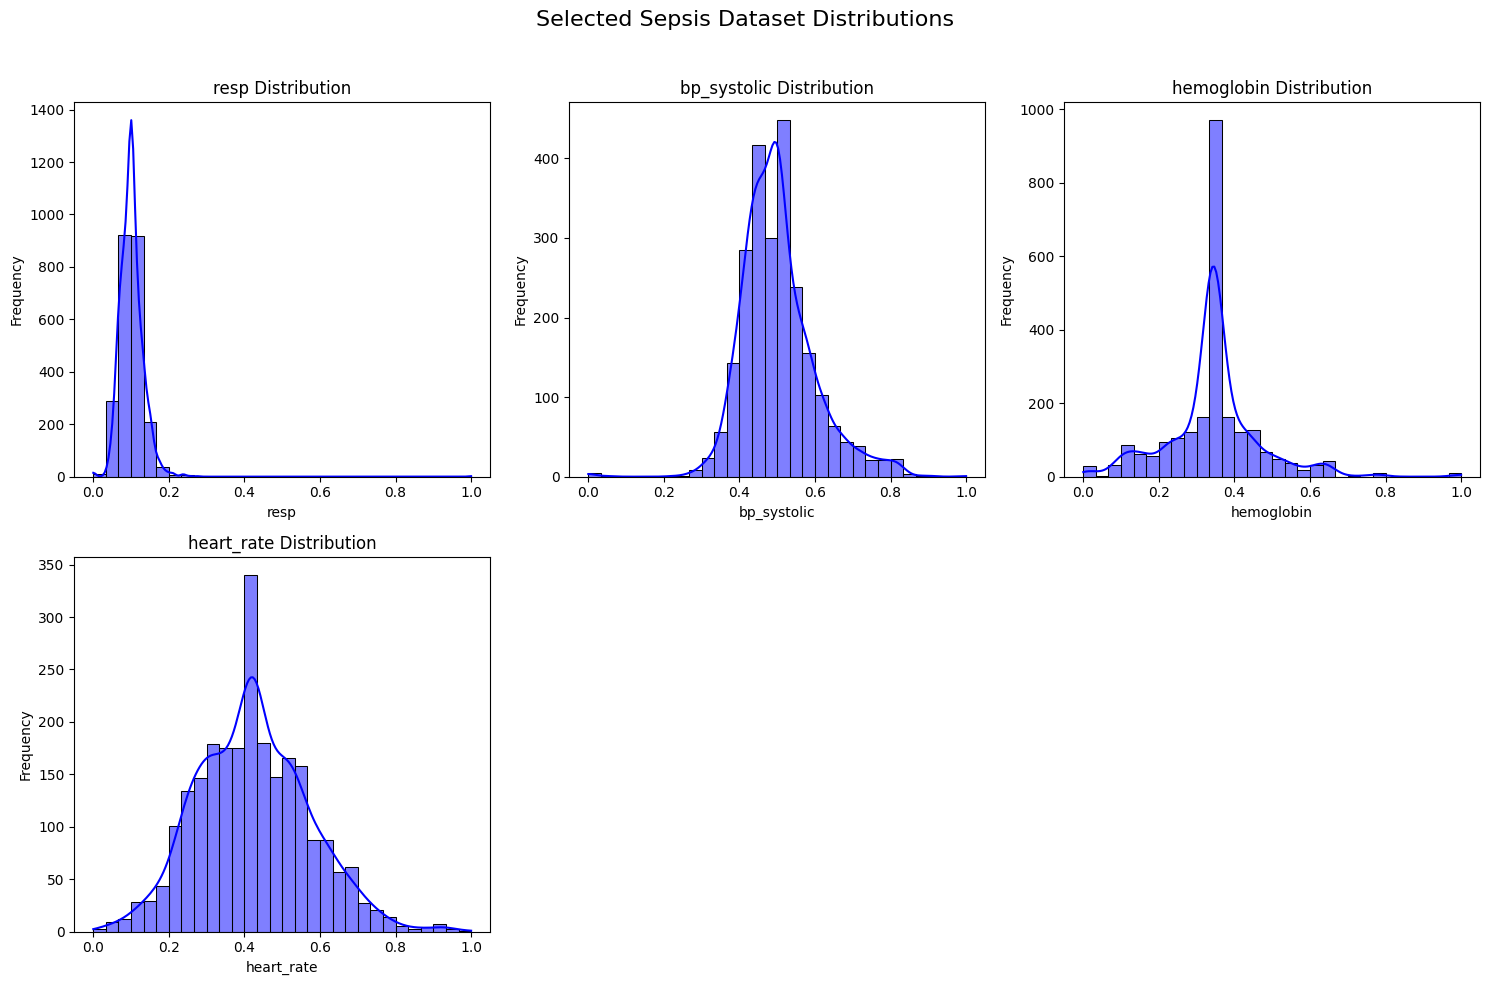

In [25]:
selected_columns = ['resp', 'bp_systolic', 'hemoglobin', 'heart_rate']  

# Filter the DataFrame to include only the selected columns
sepsis_selected_df = sepsis_filled_df[selected_columns]

visualize_data_distributions(sepsis_selected_df, title="Selected Sepsis Dataset Distributions")

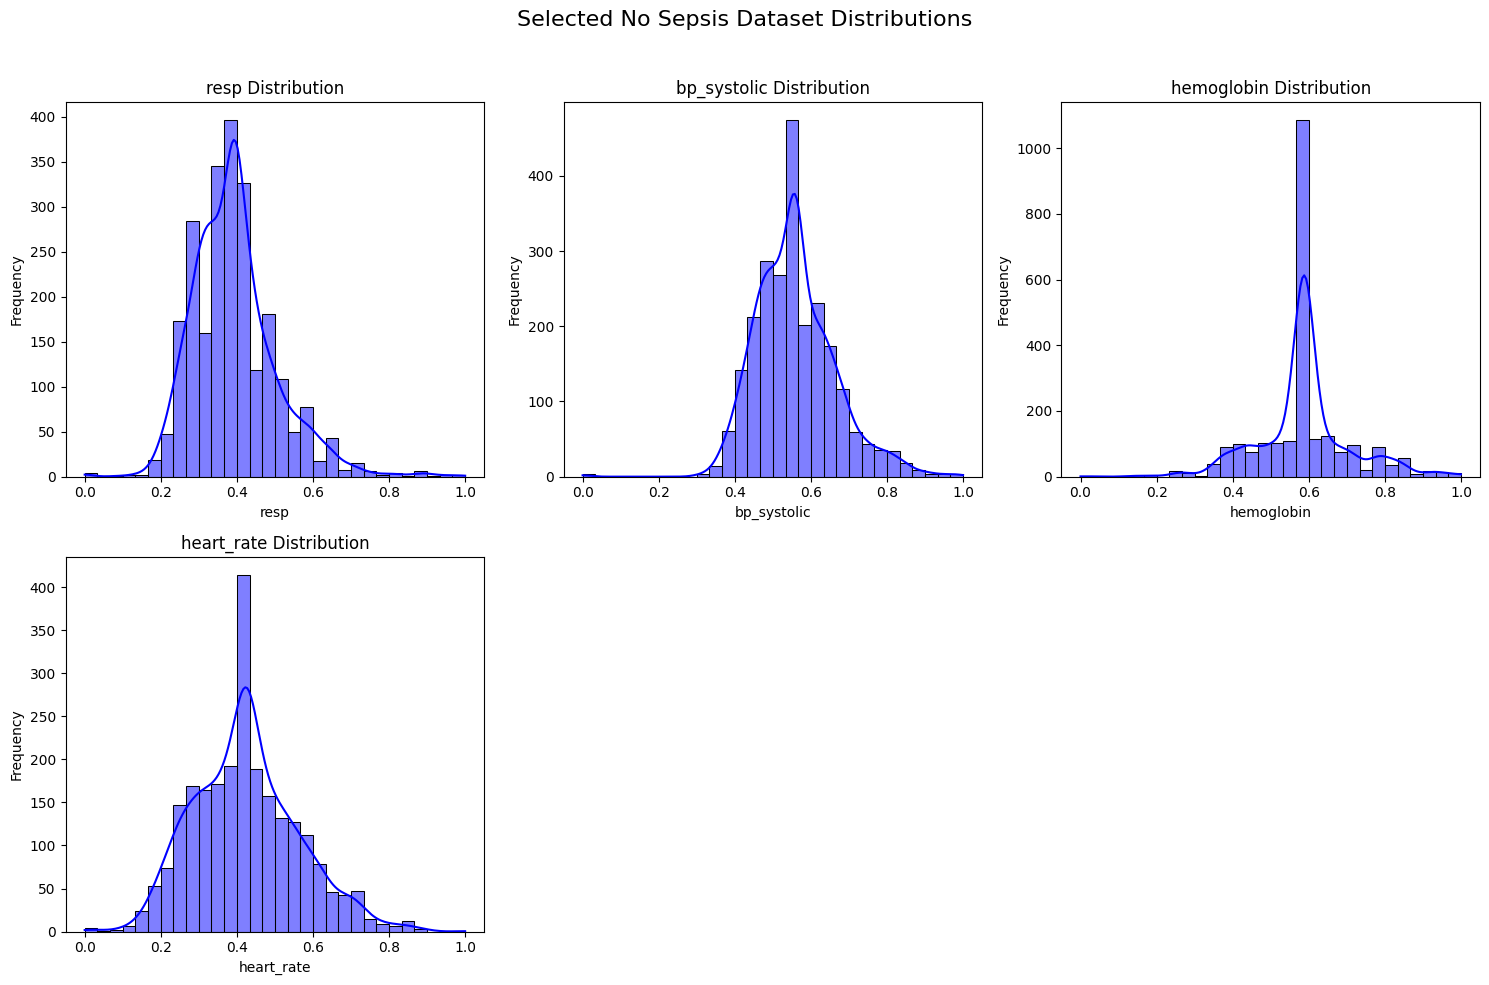

In [26]:

sepsis_selected_df = no_sepsis_filled_df[selected_columns]

visualize_data_distributions(sepsis_selected_df, title="Selected No Sepsis Dataset Distributions")

## Fuzzy Inference System Implementation

#### Printing columns that have high correlation with sepsisicd

In [27]:
threshold = 0.5
target_correlation = correlation_matrix['sepsis_icd'].sort_values(ascending=False)
important_features = target_correlation[target_correlation.abs() > threshold].index

# Drop less important features
processed_data = combined_df[important_features]
print(f"Selected Features: {list(important_features)}")


Selected Features: ['sepsis_icd', 'hematocrit', 'wbc', 'hemoglobin', 'resp']


### Application of FIS on normalized data

In [28]:
combined_df = combined_df.rename(columns={'sepsis_icd': 'label'})

In [55]:
# Define Fuzzy Sets and Membership Functions
resp = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'resp')
bp_systolic = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'bp_systolic')
hemoglobin = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'hemoglobin')
heart_rate = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'heart_rate')
# Define fuzzy variable for output
sepsis_risk = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'sepsis_risk')

# Membership functions for inputs and output
resp['low'] = fuzz.trimf(resp.universe, [0, 0, 0.5])
resp['medium'] = fuzz.trimf(resp.universe, [0.25, 0.5, 0.75])
resp['high'] = fuzz.trimf(resp.universe, [0.5, 1, 1.1])

bp_systolic['low'] = fuzz.trimf(bp_systolic.universe, [0, 0, 0.5])
bp_systolic['medium'] = fuzz.trimf(bp_systolic.universe, [0.25, 0.5, 0.75])
bp_systolic['high'] = fuzz.trimf(bp_systolic.universe, [0.5, 1, 1.1])

hemoglobin['low'] = fuzz.trimf(hemoglobin.universe, [0, 0, 0.4])
hemoglobin['medium'] = fuzz.trimf(hemoglobin.universe, [0.25, 0.5, 0.75])
hemoglobin['high'] = fuzz.trimf(hemoglobin.universe, [0.5, 1, 1.1])

heart_rate['low'] = fuzz.trimf(heart_rate.universe, [0, 0, 0.5])
heart_rate['medium'] = fuzz.trimf(heart_rate.universe, [0.25, 0.5, 0.75])
heart_rate['high'] = fuzz.trimf(heart_rate.universe, [0.5, 1, 1.1])

sepsis_risk['low'] = fuzz.trimf(sepsis_risk.universe, [0, 0, 0.5])
sepsis_risk['medium'] = fuzz.trimf(sepsis_risk.universe, [0.25, 0.5, 0.75])
sepsis_risk['high'] = fuzz.trimf(sepsis_risk.universe, [0.5, 1, 1.1])

# Define Fuzzy Rules
rule1 = ctrl.Rule(heart_rate['low'] & bp_systolic['low'] | resp['low'] , sepsis_risk['high'])
rule2 = ctrl.Rule(resp['medium'] & hemoglobin['low'], sepsis_risk['medium'])
rule3 = ctrl.Rule(hemoglobin['high'] & bp_systolic['high'] & heart_rate['medium'], sepsis_risk['low'])
rule4 = ctrl.Rule(heart_rate['medium'] & hemoglobin['low'], sepsis_risk['high'])
rule5 = ctrl.Rule(heart_rate['medium'] & bp_systolic['medium'], sepsis_risk['medium'])
rule6 = ctrl.Rule(resp['medium'] | hemoglobin['medium'], sepsis_risk['low'])


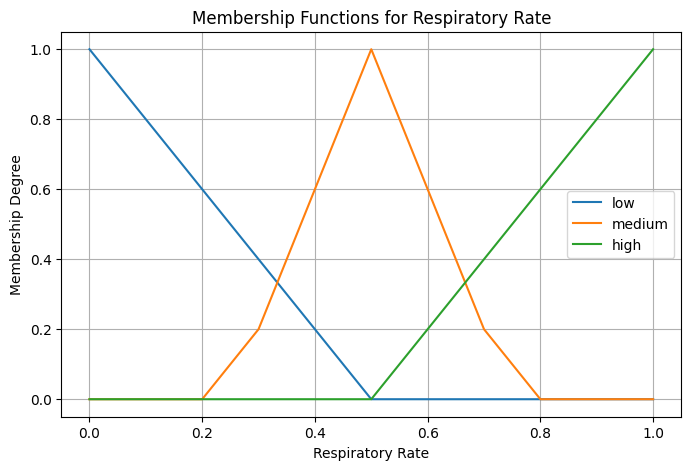

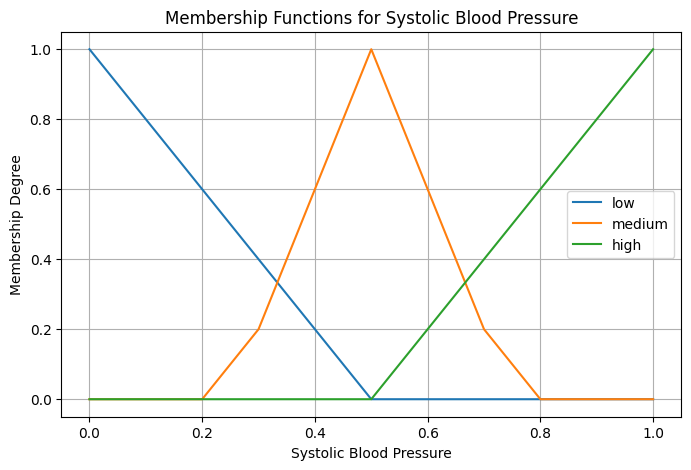

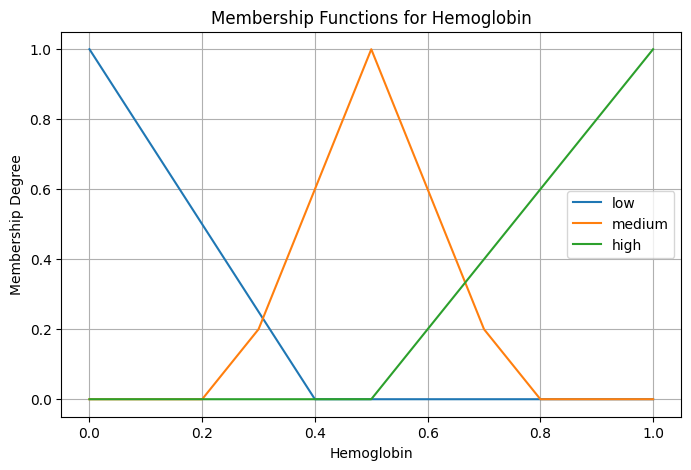

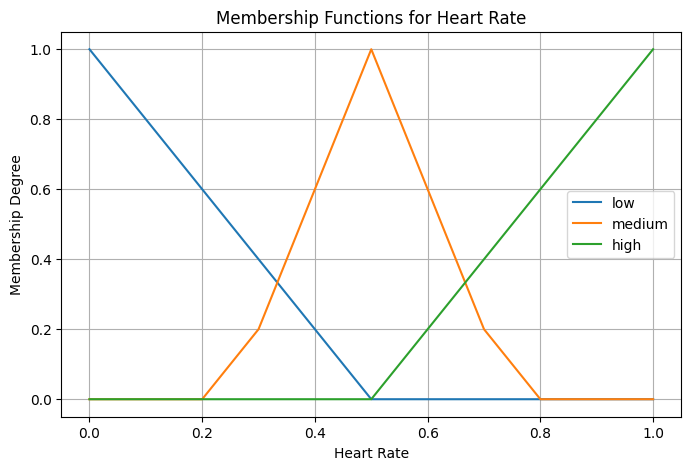

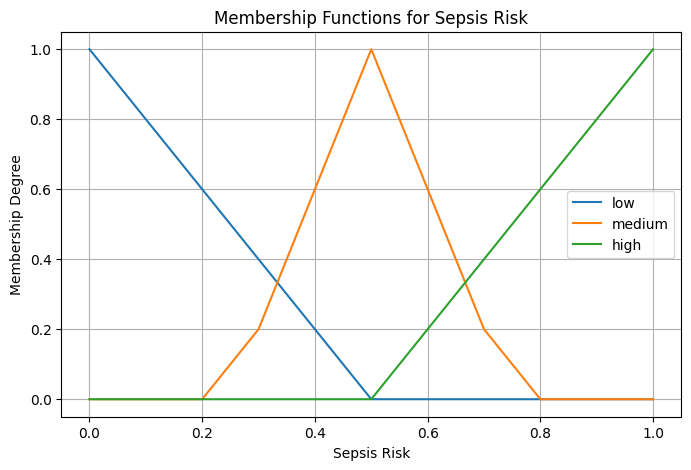

In [56]:
import matplotlib.pyplot as plt

# Function to visualize membership functions
def visualize_membership_functions(variable, variable_name):
    plt.figure(figsize=(8, 5))
    for label, membership_func in variable.terms.items():
        plt.plot(variable.universe, fuzz.interp_membership(variable.universe, membership_func.mf, variable.universe), label=label)
    plt.title(f"Membership Functions for {variable_name}")
    plt.xlabel(variable_name)
    plt.ylabel("Membership Degree")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize membership functions for each variable
visualize_membership_functions(resp, "Respiratory Rate")
visualize_membership_functions(bp_systolic, "Systolic Blood Pressure")
visualize_membership_functions(hemoglobin, "Hemoglobin")
visualize_membership_functions(heart_rate, "Heart Rate")
visualize_membership_functions(sepsis_risk, "Sepsis Risk")


TPR (Sensitivity): 0.92
FPR: 0.07
TNR (Specificity): 0.93
FNR: 0.08
Precision: 0.93
F1 Score: 0.93
Accuracy: 0.93
AUC: 0.97


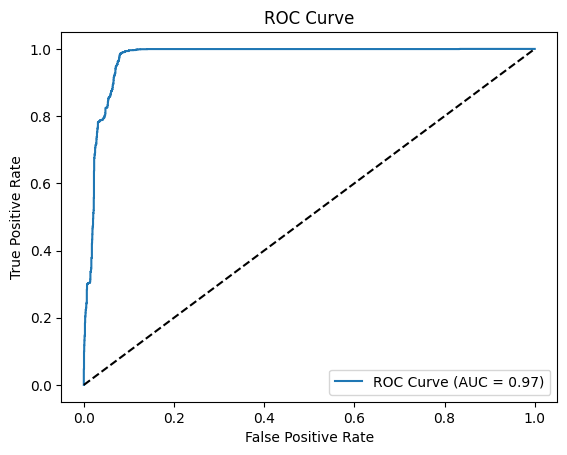

In [31]:
# Control System
sepsis_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5,rule6])
sepsis_sim = ctrl.ControlSystemSimulation(sepsis_ctrl)

# Center of Area (COA) Defuzzification Method
sepsis_risk.defuzzify_method = 'centroid'  # Center of Area (default method)

# Evaluate Model
true_labels = combined_df['label'].values
predicted_outputs = []
for i in range(len(combined_df)):
    row = combined_df.iloc[i]
    try:
        sepsis_sim.input['heart_rate'] = row['heart_rate']
        sepsis_sim.input['resp'] = row['resp']
        sepsis_sim.input['bp_systolic'] = row['bp_systolic']
        sepsis_sim.input['hemoglobin'] = row['hemoglobin']
        
        # Compute fuzzy output
        sepsis_sim.compute()
        
        # Check if output is computed
        if 'sepsis_risk' in sepsis_sim.output:
            predicted_outputs.append(sepsis_sim.output['sepsis_risk'])
        else:
            print(f"No output for row {i}. Setting default value.")
            predicted_outputs.append(0.5)  # Default value if no output is computed

    except ValueError as e:
        print(f"Error at row {i}: {e}")
        print(row)
        continue

# Threshold predictions
threshold = 0.5
predicted_labels = [1 if output >= threshold else 0 for output in predicted_outputs]

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Metrics
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * (precision * tpr) / (precision + tpr)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# ROC and AUC
auc = roc_auc_score(true_labels, predicted_outputs)
fpr_values, tpr_values, _ = roc_curve(true_labels, predicted_outputs)

# Print Metrics
print(f"TPR (Sensitivity): {tpr:.2f}")
print(f"FPR: {fpr:.2f}")
print(f"TNR (Specificity): {tnr:.2f}")
print(f"FNR: {fnr:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr_values, tpr_values, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Application of FIS on No Normalized Data

#### The correlation between sepsis and other features in the non-normalized data

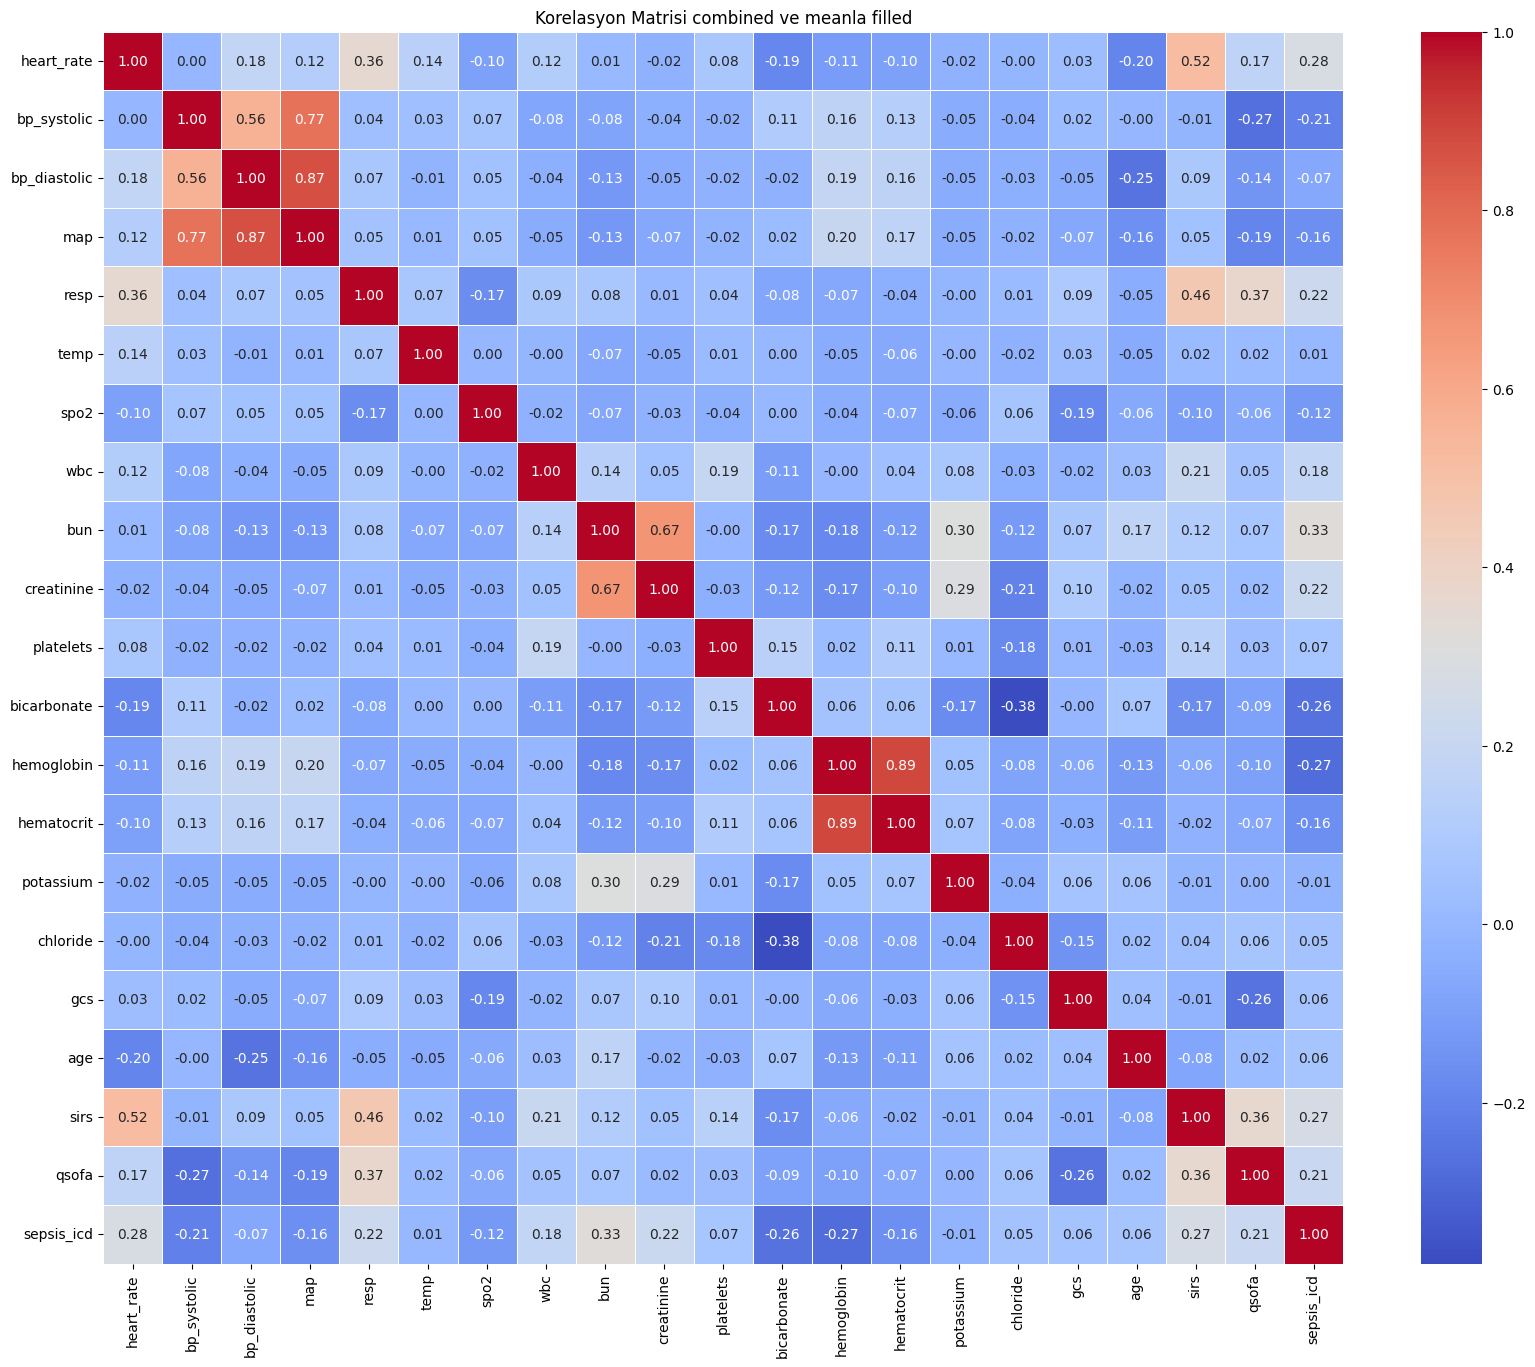

In [32]:
correlation_matrix = combined_df_filled.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Korelasyon Matrisi combined ve meanla filled")
plt.show()

#### Print the min and max values to determine the membership function ranges

In [43]:
combined_df_filled = combined_df_filled.rename(columns={'sepsis_icd': 'label'})

selected_columns = ['resp', 'bp_systolic', 'hemoglobin', 'heart_rate']  # Add your columns here

# Filter the DataFrame to include only the selected columns
sepsis_selected_df = combined_df_filled[selected_columns]
# Tüm sütunlar için maksimum ve minimum değerleri alma
max_values = sepsis_selected_df.max()
min_values = sepsis_selected_df.min()

print("The Maximum Values of All Columns :\n", max_values)
print("The Minimum Values of All Columns are:\n", min_values)



The Maximum Values of All Columns :
 resp           211.0
bp_systolic    221.0
hemoglobin      18.3
heart_rate     169.0
dtype: float64
The Minimum Values of All Columns are:
 resp            0.0
bp_systolic     0.0
hemoglobin      3.2
heart_rate     30.0
dtype: float64


In [75]:
# Define Fuzzy Sets and Membership Functions
bp_systolic = ctrl.Antecedent(np.arange(0, 250, 1), 'bp_systolic')
resp = ctrl.Antecedent(np.arange(0, 300, 1), 'resp')
hemoglobin = ctrl.Antecedent(np.arange(0, 20, 1), 'hemoglobin')
heart_rate = ctrl.Antecedent(np.arange(0, 200, 1), 'heart_rate')
# Define fuzzy variable for output
sepsis_risk = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'sepsis_risk')

# Membership functions for inputs and output
bp_systolic['low'] = fuzz.trimf(bp_systolic.universe, [0, 75, 125])
bp_systolic['medium'] = fuzz.trimf(bp_systolic.universe, [100, 145, 175])
bp_systolic['high'] = fuzz.trimf(bp_systolic.universe, [150, 200,250])

resp['low'] = fuzz.trimf(resp.universe, [0, 75, 150])
resp['medium'] = fuzz.trimf(resp.universe, [100, 180, 250])
resp['high'] = fuzz.trimf(resp.universe, [200, 250, 300])

hemoglobin['low'] = fuzz.trimf(hemoglobin.universe, [0, 5, 12])
hemoglobin['medium'] = fuzz.trimf(hemoglobin.universe, [10, 13, 15])
hemoglobin['high'] = fuzz.trimf(hemoglobin.universe, [15, 18, 20])

heart_rate['low'] = fuzz.trimf(heart_rate.universe, [0, 40, 60])
heart_rate['medium'] = fuzz.trimf(heart_rate.universe, [55, 80,100])
heart_rate['high'] = fuzz.trimf(heart_rate.universe, [90, 150, 200])

sepsis_risk['low'] = fuzz.trimf(sepsis_risk.universe, [0, 0, 0.5])
sepsis_risk['medium'] = fuzz.trimf(sepsis_risk.universe, [0.25, 0.5, 0.75])
sepsis_risk['high'] = fuzz.trimf(sepsis_risk.universe, [0.5, 1, 1.1])

# Define Fuzzy Rules
rule1 = ctrl.Rule(heart_rate['low'] & bp_systolic['low'] | resp['low'] , sepsis_risk['high'])
rule2 = ctrl.Rule(resp['medium'] & hemoglobin['low'], sepsis_risk['medium'])
rule3 = ctrl.Rule(hemoglobin['high'] & bp_systolic['high'] & heart_rate['medium'], sepsis_risk['low'])
rule4 = ctrl.Rule(heart_rate['medium'] & hemoglobin['low'], sepsis_risk['high'])
rule5 = ctrl.Rule(heart_rate['medium'] & bp_systolic['medium'], sepsis_risk['medium'])
rule6 = ctrl.Rule(resp['medium'] | hemoglobin['medium'], sepsis_risk['low'])


# Add rules to control system
sepsis_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])

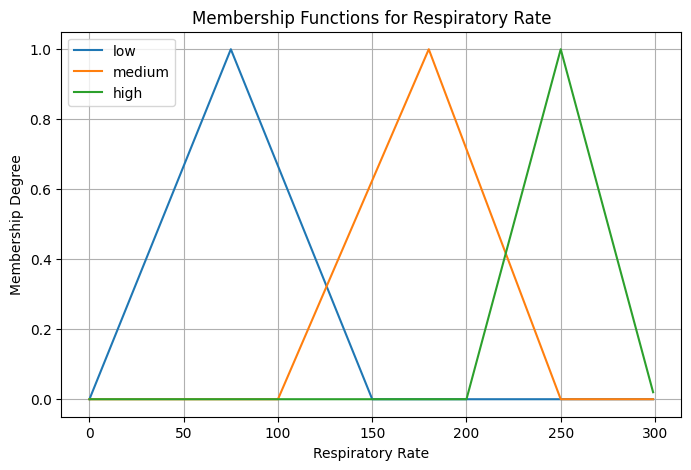

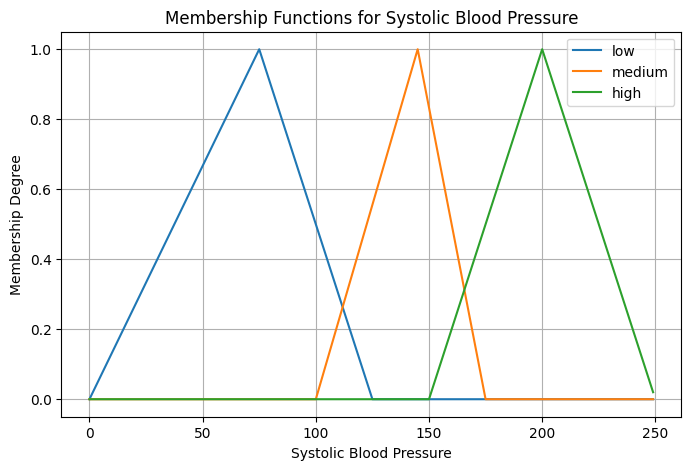

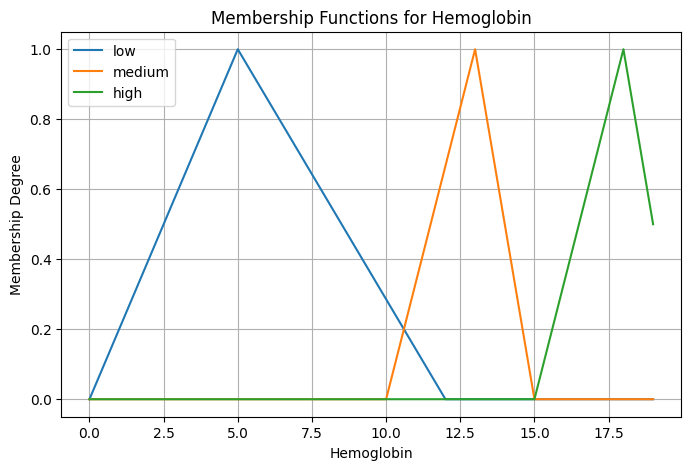

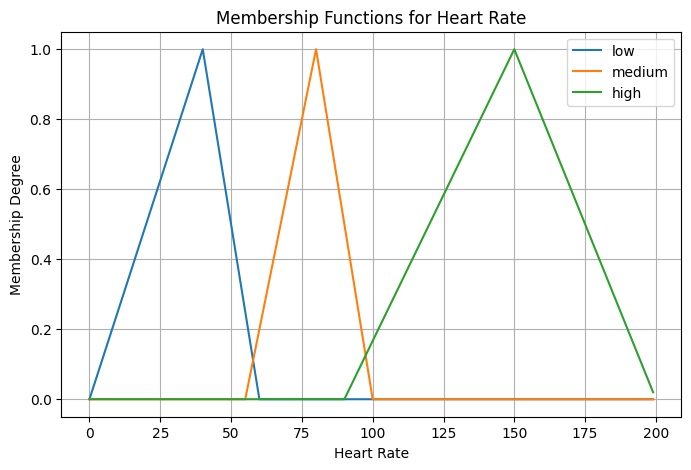

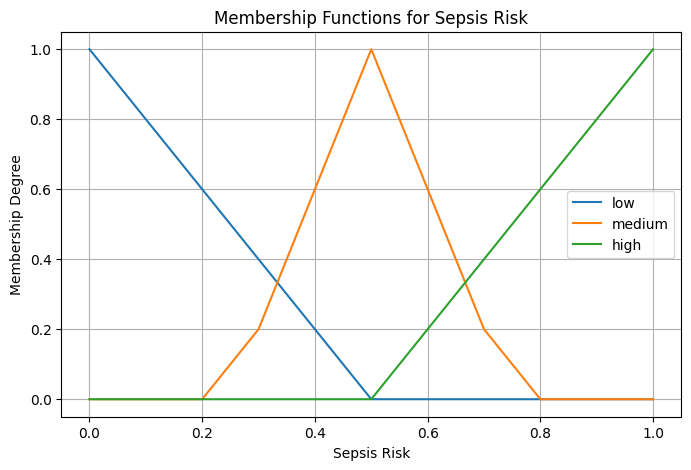

In [76]:
# Visualize membership functions for each variable
visualize_membership_functions(resp, "Respiratory Rate")
visualize_membership_functions(bp_systolic, "Systolic Blood Pressure")
visualize_membership_functions(hemoglobin, "Hemoglobin")
visualize_membership_functions(heart_rate, "Heart Rate")
visualize_membership_functions(sepsis_risk, "Sepsis Risk")

No output for row 2525. Setting default value.
No output for row 4301. Setting default value.
TPR (Sensitivity): 0.79
FPR: 0.34
TNR (Specificity): 0.66
FNR: 0.21
Precision: 0.70
F1 Score: 0.74
Accuracy: 0.73
AUC: 0.74


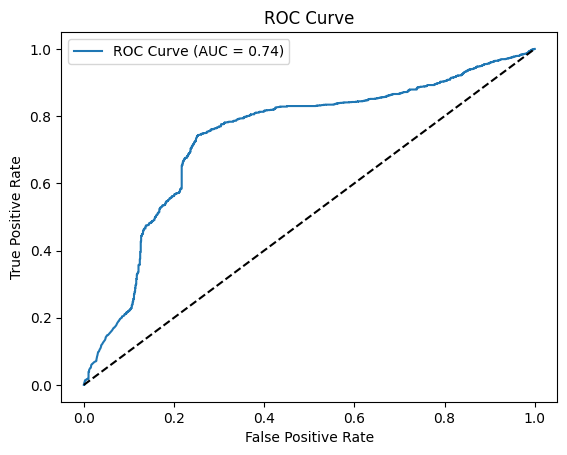

In [77]:
# Control System
sepsis_sim = ctrl.ControlSystemSimulation(sepsis_ctrl)

# Evaluate Model
true_labels = combined_df_filled['label'].values
predicted_outputs = []
for i in range(len(combined_df_filled)):
    row = combined_df_filled.iloc[i]
    try:
        sepsis_sim.input['heart_rate'] = row['heart_rate']
        sepsis_sim.input['bp_systolic'] = row['bp_systolic']
        sepsis_sim.input['resp'] = row['resp']
        sepsis_sim.input['hemoglobin'] = row['hemoglobin']
        
        # Compute fuzzy output
        sepsis_sim.compute()
        
        # Check if output is computed
        if 'sepsis_risk' in sepsis_sim.output:
            predicted_outputs.append(sepsis_sim.output['sepsis_risk'])
        else:
            print(f"No output for row {i}. Setting default value.")
            predicted_outputs.append(0.5)  # Default value if no output is computed

    except ValueError as e:
        print(f"Error at row {i}: {e}")
        print(row)
        continue

# Threshold predictions
threshold = 0.5
predicted_labels = [1 if output >= threshold else 0 for output in predicted_outputs]

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Metrics
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * (precision * tpr) / (precision + tpr)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# ROC and AUC
auc = roc_auc_score(true_labels, predicted_outputs)
fpr_values, tpr_values, _ = roc_curve(true_labels, predicted_outputs)

# Print Metrics
print(f"TPR (Sensitivity): {tpr:.2f}")
print(f"FPR: {fpr:.2f}")
print(f"TNR (Specificity): {tnr:.2f}")
print(f"FNR: {fnr:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr_values, tpr_values, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()